In [ ]:
# Checking GPU availability and basic info
!nvidia-smi


Sun Nov  2 12:00:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!git clone https://github.com/rapidsai-community/rapidsai-csp-utils.git

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 603, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 603 (delta 131), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (603/603), 199.38 KiB | 18.13 MiB/s, done.
Resolving deltas: 100% (305/305), done.


In [ ]:
!python rapidsai-csp-utils/colab/install_rapids.py stable

Found existing installation: cffi 2.0.0
Uninstalling cffi-2.0.0:
  Successfully uninstalled cffi-2.0.0
Found existing installation: cryptography 43.0.3
Uninstalling cryptography-43.0.3:
  Successfully uninstalled cryptography-43.0.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.1/484.1 kB 29.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for cffi: filename=cffi-1.15.0-cp312-cp312-linux_x86_64.whl size=400941 sha256=fe8665f32e350d26075914e9bd8633843e2aeea7705aee0912bbf765edc252a8
  Stored in directory: /root/.cache/pip/wheels/b9/d6/15/0950847bf7d74ea5f0380b8b23a1d81b45bdf48488b4b8237a
Successfully built cffi
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rpy2 3.5.17 requires cffi>=1.15.1, but you have cffi 1.15.0 which is incompatible.
pygit2 1.19.0 requires cffi>=2.0, b

In [ ]:
import time
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Import RAPIDS libraries (cuDF & cuML)
try:
    import cudf
    import cupy as cp
    from cuml.ensemble import RandomForestClassifier as cuRF
    from cuml.linear_model import LogisticRegression as cuLogistic
    from cuml.neighbors import KNeighborsClassifier as cuKNN
    from cuml.svm import SVC as cuSVC
    RAPIDS_AVAILABLE = True
except Exception as e:
    print("RAPIDS import error (proceeding may fail):", e)
    RAPIDS_AVAILABLE = False

# CPU sklearn imports
from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn.linear_model import LogisticRegression as skLogistic
from sklearn.neighbors import KNeighborsClassifier as skKNN
from sklearn.svm import SVC as skSVC

# Utility: time wrapper
def timed(f, *args, **kwargs):
    t0 = time.perf_counter()
    out = f(*args, **kwargs)
    t1 = time.perf_counter()
    return out, t1 - t0


Load California Housing and create classification labels

In [ ]:
# Load dataset (sklearn)
data = fetch_california_housing(as_frame=True)
X_pd = data.frame.drop(columns=['MedHouseVal'])
y_reg = data.frame['MedHouseVal']

# Convert regression target into 3 classes using quantiles:
# 0 = low (<=33rd pct), 1 = medium (33-66 pct), 2 = high (>66 pct)
q1 = np.quantile(y_reg, 1/3)
q2 = np.quantile(y_reg, 2/3)

def bin_target(val):
    if val <= q1:
        return 0
    elif val <= q2:
        return 1
    else:
        return 2

y_pd = y_reg.apply(bin_target)

print("Dataset shape:", X_pd.shape)
print("Class distribution:\n", y_pd.value_counts(normalize=True))


Dataset shape: (20640, 8)
Class distribution:
 MedHouseVal
0    0.333527
2    0.333333
1    0.333140
Name: proportion, dtype: float64


Train-test split and scaling (CPU pandas), then convert to cuDF

In [ ]:
# Train-test split (do this on CPU)
X_train_pd, X_test_pd, y_train_pd, y_test_pd = train_test_split(
    X_pd, y_pd, test_size=0.2, random_state=42, stratify=y_pd
)

# Standard scale (sklearn) — CPU, then convert
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pd)
X_test_scaled = scaler.transform(X_test_pd)

# Convert back to pandas DataFrame (so dtype columns are preserved)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_pd.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_pd.columns)

# Convert to cuDF (for GPU models)
if RAPIDS_AVAILABLE:
    X_train_cudf = cudf.from_pandas(X_train_scaled.astype('float32'))
    X_test_cudf = cudf.from_pandas(X_test_scaled.astype('float32'))
    y_train_cudf = cudf.Series(y_train_pd.values.astype('int32'))
    y_test_cudf = cudf.Series(y_test_pd.values.astype('int32'))
else:
    X_train_cudf = None
    X_test_cudf = None
    y_train_cudf = None
    y_test_cudf = None

# Convert CPU arrays for sklearn
X_train_np = X_train_scaled.values.astype('float32')
X_test_np = X_test_scaled.values.astype('float32')
y_train_np = y_train_pd.values.astype('int32')
y_test_np = y_test_pd.values.astype('int32')

print("Prepared training set:", X_train_np.shape)


Prepared training set: (16512, 8)


Model training & benchmarking helper

In [ ]:
# Helper to train and evaluate CPU & GPU models and return times + accuracy
def benchmark_sklearn(model_class, model_kwargs=None):
    model_kwargs = model_kwargs or {}
    model = model_class(**model_kwargs)
    _, train_time = timed(model.fit, X_train_np, y_train_np)
    preds, pred_time = timed(model.predict, X_test_np)
    acc = accuracy_score(y_test_np, preds)
    return {'train_time': train_time, 'pred_time': pred_time, 'accuracy': acc, 'model': model}

def benchmark_cuml(model_class, model_kwargs=None):
    if not RAPIDS_AVAILABLE:
        raise RuntimeError("RAPIDS not available.")
    model_kwargs = model_kwargs or {}
    model = model_class(**model_kwargs)
    # cuml expects cuDF / cupy arrays
    _, train_time = timed(model.fit, X_train_cudf, y_train_cudf)
    preds, pred_time = timed(model.predict, X_test_cudf)
    # preds is cuDF/cupy — convert to host numpy for accuracy
    try:
        preds_host = preds.to_array() if hasattr(preds, 'to_array') else preds.get()
    except Exception:
        preds_host = cp.asnumpy(preds) if hasattr(cp, 'asnumpy') else preds
    preds_host = np.array(preds_host).astype('int32').ravel()
    acc = accuracy_score(y_test_np, preds_host)
    return {'train_time': train_time, 'pred_time': pred_time, 'accuracy': acc, 'model': model}


Run benchmarks for core algorithms (RF, Logistic, KNN, SVM)

In [ ]:
results = {}

# Random Forest
print("Benchmarking Random Forest...")
results['sk_RF'] = benchmark_sklearn(skRF, {'n_estimators':100, 'random_state':42, 'n_jobs':-1})
if RAPIDS_AVAILABLE:
    results['cu_RF'] = benchmark_cuml(cuRF, {'n_estimators':100, 'max_depth':16, 'n_streams':4})

# Logistic Regression
print("Benchmarking Logistic Regression...")
results['sk_Log'] = benchmark_sklearn(skLogistic, {'max_iter':200})
if RAPIDS_AVAILABLE:
    results['cu_Log'] = benchmark_cuml(cuLogistic, {'max_iter':200, 'penalty':'l2'})

# KNN
print("Benchmarking KNN...")
results['sk_KNN'] = benchmark_sklearn(skKNN, {'n_neighbors':5, 'n_jobs':-1})
if RAPIDS_AVAILABLE:
    results['cu_KNN'] = benchmark_cuml(cuKNN, {'n_neighbors':5})

# SVM
print("Benchmarking SVM (this can be slow on CPU)...")
results['sk_SVM'] = benchmark_sklearn(skSVC, {'kernel':'rbf', 'gamma':'scale'})
if RAPIDS_AVAILABLE:
    try:
        results['cu_SVM'] = benchmark_cuml(cuSVC, {'kernel': 'rbf'})
    except Exception as e:
        print("cuSVC failed or unavailable:", e)

# Show brief summary
for k, v in results.items():
    print(f"{k}: train {v['train_time']:.3f}s  pred {v['pred_time']:.3f}s  acc {v['accuracy']:.4f}")


Benchmarking Random Forest...
Benchmarking Logistic Regression...
Benchmarking KNN...
Benchmarking SVM (this can be slow on CPU)...
sk_RF: train 3.144s  pred 0.076s  acc 0.8089
cu_RF: train 2.228s  pred 1.143s  acc 0.7827
sk_Log: train 0.155s  pred 0.005s  acc 0.7156
cu_Log: train 1.217s  pred 0.119s  acc 0.7151
sk_KNN: train 0.019s  pred 0.249s  acc 0.7127
cu_KNN: train 0.003s  pred 0.754s  acc 0.7127
sk_SVM: train 7.386s  pred 1.930s  acc 0.7481
cu_SVM: train 1.688s  pred 0.131s  acc 0.7493


Visualize comparisons

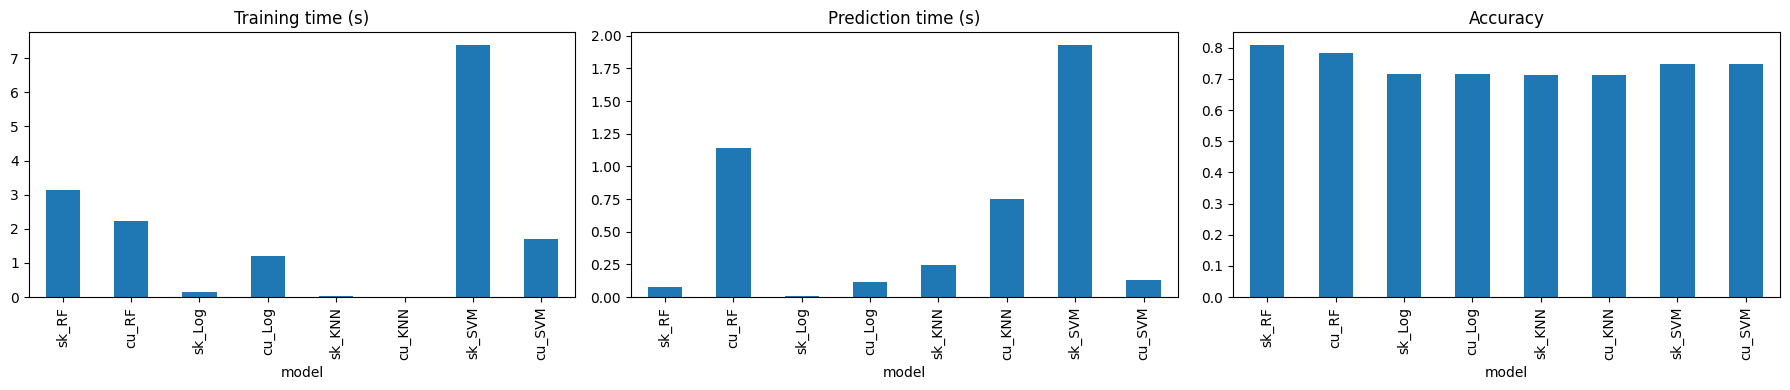

,model,train_time,pred_time,accuracy
0,sk_RF,3.143518,0.076027,0.808866
1,cu_RF,2.227832,1.143181,0.782703
2,sk_Log,0.155365,0.004652,0.715601
3,cu_Log,1.217132,0.119262,0.715116
4,sk_KNN,0.019453,0.248653,0.712694
5,cu_KNN,0.003239,0.753641,0.712694
6,sk_SVM,7.386361,1.929593,0.748062
7,cu_SVM,1.687709,0.130871,0.749273


In [ ]:
# Convert results to DataFrame
rows = []
for k, v in results.items():
    rows.append({'model': k, 'train_time': v['train_time'], 'pred_time': v['pred_time'], 'accuracy': v['accuracy']})
res_df = pd.DataFrame(rows)

# Plot training time
fig, ax = plt.subplots(1,3, figsize=(18,4))
res_df.plot.bar(x='model', y='train_time', ax=ax[0], legend=False)
ax[0].set_title('Training time (s)')
res_df.plot.bar(x='model', y='pred_time', ax=ax[1], legend=False)
ax[1].set_title('Prediction time (s)')
res_df.plot.bar(x='model', y='accuracy', ax=ax[2], legend=False)
ax[2].set_title('Accuracy')
plt.tight_layout()
plt.show()
res_df


Simple batching example for out-of-memory inference on GPU

In [ ]:
# If test set is large, do batched prediction on GPU
def batched_predict_cuml(model, X_cudf, batch_size=10000):
    n = len(X_cudf)
    preds_list = []
    for i in range(0, n, batch_size):
        part = X_cudf[i: i+batch_size]
        p = model.predict(part)
        preds_list.append(p)
    # concat
    try:
        preds_concat = cudf.concat(preds_list).to_array()
    except Exception:
        # fallback convert to numpy
        preds_concat = np.concatenate([cp.asnumpy(p) if hasattr(cp,'asnumpy') else p for p in preds_list])
    return preds_concat

if RAPIDS_AVAILABLE and 'cu_RF' in results:
    model = results['cu_RF']['model']
    t0 = time.perf_counter()
    preds_batched = batched_predict_cuml(model, X_test_cudf, batch_size=2000)
    t1 = time.perf_counter()
    print("Batched GPU prediction time (s):", t1 - t0)
    print("Batched_accuracy:", accuracy_score(y_test_np, preds_batched.astype('int32').ravel()))


Batched GPU prediction time (s): 0.4262176180000097
Batched_accuracy: 0.782703488372093


Simple hyperparameter sweep (example for Random Forest)

In [ ]:
# Quick GPU hyperparameter sweep (small grid)
sweep_results = []
params_grid = [{'n_estimators':50}, {'n_estimators':100}, {'n_estimators':200}]
if RAPIDS_AVAILABLE:
    for p in params_grid:
        try:
            model = cuRF(**p, max_depth=16)
            _, t = timed(model.fit, X_train_cudf, y_train_cudf)
            preds = model.predict(X_test_cudf)
            preds_np = preds.to_array() if hasattr(preds, 'to_array') else cp.asnumpy(preds)
            acc = accuracy_score(y_test_np, np.array(preds_np).astype('int32').ravel())
            sweep_results.append({'params': p, 'train_time': t, 'accuracy': acc})
            print(p, "train_time:", t, "acc:", acc)
        except Exception as e:
            print("Error for params", p, e)

pd.DataFrame(sweep_results)


{'n_estimators': 50} train_time: 0.22910397800001192 acc: 0.783187984496124
{'n_estimators': 100} train_time: 0.29755913099995723 acc: 0.782703488372093
{'n_estimators': 200} train_time: 0.5062168300000849 acc: 0.7882751937984496


,params,train_time,accuracy
0,{'n_estimators': 50},0.229104,0.783188
1,{'n_estimators': 100},0.297559,0.782703
2,{'n_estimators': 200},0.506217,0.788275
